In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from torchvision.transforms import ToTensor
from tqdm import tqdm
from tqdm import tqdm_notebook as tqdm
import cv2
import os
from torch.utils.data import TensorDataset, DataLoader
import matplotlib as plt
%matplotlib inline
import pandas as pd
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
from PIL import Image
from sklearn.utils.class_weight import compute_class_weight
from glob import glob
from skimage.io import imread
from os import listdir
import time
import copy
import random

C:\Users\alvaro.rlanceta\AppData\Local\anaconda3\Lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [4]:
root_dir = "\\DatasetPacientes"  # Ruta del directorio de imágenes DatasetPacientes

N_IDC = []
P_IDC = []

for dir_name in tqdm(os.listdir(root_dir)):
    dir_path = os.path.join(root_dir, dir_name)
    if os.path.isdir(dir_path):
        negative_dir_path = os.path.join(dir_path, '0')
        positive_dir_path = os.path.join(dir_path, '1')
        if os.path.isdir(negative_dir_path) and os.path.isdir(positive_dir_path):
            negative_image_paths = [
                os.path.join(negative_dir_path, image_name)
                for image_name in os.listdir(negative_dir_path)
                if image_name.endswith('.png')
            ]
            positive_image_paths = [
                os.path.join(positive_dir_path, image_name)
                for image_name in os.listdir(positive_dir_path)
                if image_name.endswith('.png')
            ]
            N_IDC.extend(negative_image_paths)
            P_IDC.extend(positive_image_paths)

total_images = 60000  

n_img_arr = np.zeros(shape=(total_images, 50, 50, 3), dtype=np.float32)
p_img_arr = np.zeros(shape=(total_images, 50, 50, 3), dtype=np.float32)
label_n = np.zeros(total_images)
label_p = np.ones(total_images)

for i, img in tqdm(enumerate(N_IDC[:total_images])):
    n_img = cv2.imread(img, cv2.IMREAD_COLOR)
    n_img_size = cv2.resize(n_img, (50, 50), interpolation=cv2.INTER_LINEAR)
    n_img_arr[i] = n_img_size

for i, img in tqdm(enumerate(P_IDC[:total_images])):
    p_img = cv2.imread(img, cv2.IMREAD_COLOR)
    p_img_size = cv2.resize(p_img, (50, 50), interpolation=cv2.INTER_LINEAR)
    p_img_arr[i] = p_img_size

X = np.concatenate((p_img_arr, n_img_arr), axis=0)
y = np.concatenate((label_p, label_n), axis=0)
X, y = shuffle(X, y, random_state=0)

# probar --> y = to_categorical(y)

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)


  0%|          | 0/280 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [25]:
len(X_train)

86400

In [5]:


class CNN(nn.Module):
    def __init__(self, output_size=2):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=4, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.dropout1 = nn.Dropout2d(p=0.3)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(12 * 12 * 64, 64)
        self.bn5 = nn.BatchNorm1d(64)
        self.fc2 = nn.Linear(64, 64)
        self.dropout2 = nn.Dropout(p=0.3)
        self.fc3 = nn.Linear(64, 24)
        self.fc4 = nn.Linear(24, output_size)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.bn1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.bn2(x)
        x = self.maxpool1(x)
        x = self.dropout1(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.bn3(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = self.bn4(x)
        x = self.maxpool2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.bn5(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)
        x = F.softmax(x, dim=1)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN().to(device)
criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(model.parameters(), lr=0.001)



In [6]:

def train(model, device, train_loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)
    return train_loss

def evaluate(model, device, val_loader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            val_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    val_loss /= len(val_loader)
    accuracy = 100.0 * correct / len(val_loader.dataset)
    return val_loss, accuracy

In [7]:
import datetime

# Tiempo inicial
start_time = datetime.datetime.now()
batch_size = 32  # Define the batch size
train_dataset = TensorDataset(torch.from_numpy(X_train).float().permute(0, 3, 1, 2), torch.from_numpy(y_train).long())
val_dataset = TensorDataset(torch.from_numpy(X_val).float().permute(0, 3, 1, 2), torch.from_numpy(y_val).long())
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

num_epochs = 40
best_val_loss = float('inf')
losses = {"train": [], "val": []}
hist = {"train": [], "val": []}

for epoch in range(num_epochs):
    train_loss = train(model, device, train_loader, optimizer, criterion)
    val_loss, val_accuracy = evaluate(model, device, val_loader, criterion)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pt')

    losses["train"].append(train_loss)
    losses["val"].append(val_loss)
    hist["train"].append(val_accuracy)
    hist["val"].append(val_accuracy)

    print('Epoch: {:02d}, Train Loss: {:.4f}, Val Loss: {:.4f}, Val Accuracy: {:.2f}%'.format(
        epoch, train_loss, val_loss, val_accuracy))

# Load the best model
model.load_state_dict(torch.load('best_model.pt'))



Epoch: 00, Train Loss: 0.4714, Val Loss: 0.5365, Val Accuracy: 75.56%
Epoch: 01, Train Loss: 0.4586, Val Loss: 0.4813, Val Accuracy: 82.28%
Epoch: 02, Train Loss: 0.4530, Val Loss: 0.4411, Val Accuracy: 86.53%
Epoch: 03, Train Loss: 0.4493, Val Loss: 0.4490, Val Accuracy: 85.73%
Epoch: 04, Train Loss: 0.4462, Val Loss: 0.4376, Val Accuracy: 86.82%
Epoch: 05, Train Loss: 0.4435, Val Loss: 0.4408, Val Accuracy: 86.45%
Epoch: 06, Train Loss: 0.4419, Val Loss: 0.4382, Val Accuracy: 86.94%
Epoch: 07, Train Loss: 0.4394, Val Loss: 0.4456, Val Accuracy: 86.43%
Epoch: 08, Train Loss: 0.4385, Val Loss: 0.4859, Val Accuracy: 81.97%
Epoch: 09, Train Loss: 0.4354, Val Loss: 0.4328, Val Accuracy: 87.33%
Epoch: 10, Train Loss: 0.4336, Val Loss: 0.4358, Val Accuracy: 87.17%
Epoch: 11, Train Loss: 0.4314, Val Loss: 0.4373, Val Accuracy: 86.70%
Epoch: 12, Train Loss: 0.4295, Val Loss: 0.4301, Val Accuracy: 87.93%
Epoch: 13, Train Loss: 0.4285, Val Loss: 0.4645, Val Accuracy: 84.60%
Epoch: 14, Train Los

<All keys matched successfully>

In [8]:
end_time = datetime.datetime.now()

# Calculando la diferencia de tiempo
duration = end_time - start_time

print(f"Tiempo de ejecución: {duration}")

Tiempo de ejecución: 2:02:58.436996


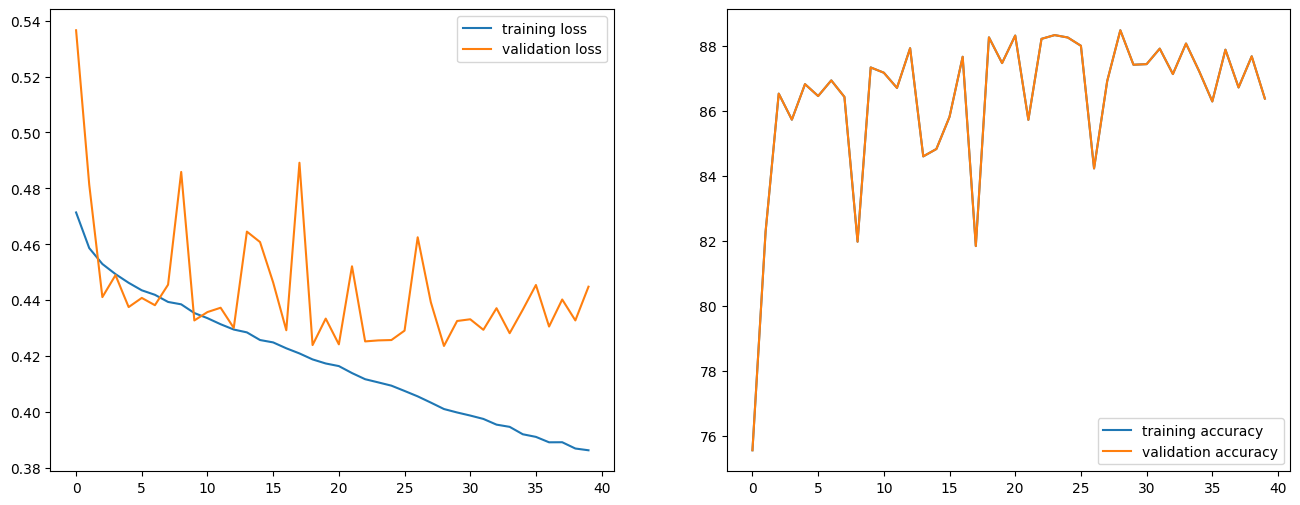

In [10]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.plot(losses["train"], label="training loss")
ax1.plot(losses["val"], label="validation loss")
ax1.legend()

ax2.plot(hist["train"], label="training accuracy")
ax2.plot(hist["val"], label="validation accuracy")
ax2.legend()

plt.show()

In [11]:
# Evaluate on the test set
test_dataset = TensorDataset(torch.from_numpy(X_test).float().permute(0, 3, 1, 2), torch.from_numpy(y_test).long())
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
test_loss, test_accuracy = evaluate(model, device, test_loader, criterion)

print('Test Loss: {:.4f}, Test Accuracy: {:.2f}%'.format(test_loss, test_accuracy))

Test Loss: 0.4248, Test Accuracy: 88.20%


In [29]:
from sklearn.metrics import classification_report

test_dataset = TensorDataset(torch.from_numpy(X_test).float().permute(0, 3, 1, 2), torch.from_numpy(y_test).long())
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model.eval()
def evaluate_and_predict(model, device, loader):
    model.eval()
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            preds = output.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
    return all_targets, all_preds
y_true, y_pred = evaluate_and_predict(model, device, test_loader)
report = classification_report(y_true, y_pred, target_names=['0', '1'])  # Adjust class names as needed
print(report)


              precision    recall  f1-score   support

           0       0.90      0.86      0.88      6040
           1       0.87      0.90      0.88      5960

    accuracy                           0.88     12000
   macro avg       0.88      0.88      0.88     12000
weighted avg       0.88      0.88      0.88     12000



### Visualize the results

In [12]:
#Iterate over the test data and make predictions
list_img_names = []

counter = 0
for i, (inputs, labels) in enumerate(test_loader):
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

    for j in range(inputs.size(0)):
        # Obtener el nombre de la imagen
        image_index = i * test_loader.batch_size + j
        image_path = N_IDC[image_index] if preds[j].item() == 0 else P_IDC[image_index]
        image_name = os.path.basename(image_path)
        print("Nombre de la imagen: {}".format(image_name))
        list_img_names.append(image_name)
        # Loading and showing the image
        image = inputs[j].permute(1, 2, 0).cpu().numpy()

        # Normalizing the image
        image = (image - image.min()) / (image.max() - image.min())

        """
        plt.figure()
        plt.imshow(image)
        plt.axis('off')
        plt.show()
        """
        # Print the prediction and the correct label
        prediction = preds[j].item()
        correct_label = labels[j].item()
        print("Predicción: {}, Etiqueta correcta: {}".format(prediction, correct_label), "\n")


Nombre de la imagen: 10253_idx5_x501_y351_class1.png
Predicción: 1, Etiqueta correcta: 0 

Nombre de la imagen: 10253_idx5_x1001_y1051_class0.png
Predicción: 0, Etiqueta correcta: 1 

Nombre de la imagen: 10253_idx5_x551_y301_class1.png
Predicción: 1, Etiqueta correcta: 1 

Nombre de la imagen: 10253_idx5_x1001_y1151_class0.png
Predicción: 0, Etiqueta correcta: 0 

Nombre de la imagen: 10253_idx5_x551_y401_class1.png
Predicción: 1, Etiqueta correcta: 0 

Nombre de la imagen: 10253_idx5_x1001_y1251_class0.png
Predicción: 0, Etiqueta correcta: 0 

Nombre de la imagen: 10253_idx5_x1001_y1301_class0.png
Predicción: 0, Etiqueta correcta: 0 

Nombre de la imagen: 10253_idx5_x551_y701_class1.png
Predicción: 1, Etiqueta correcta: 1 

Nombre de la imagen: 10253_idx5_x1001_y1501_class0.png
Predicción: 0, Etiqueta correcta: 0 

Nombre de la imagen: 10253_idx5_x601_y301_class1.png
Predicción: 1, Etiqueta correcta: 1 

Nombre de la imagen: 10253_idx5_x1001_y1701_class0.png
Predicción: 0, Etiqueta c

In [13]:
patient_ids = []
for name in list_img_names:
    id = name.split('_')[0]
    patient_ids.append(id)

In [14]:
ids_unique = list(set(patient_ids))


In [15]:
base_path = root_dir

In [18]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image
from sklearn.utils.class_weight import compute_class_weight

from glob import glob
from skimage.io import imread
from os import listdir

import time
import copy
from tqdm import tqdm_notebook as tqdm
import random




In [19]:
def get_cancer_dataframe(patient_id, cancer_id):
    path = os.path.join(base_path, patient_id, cancer_id)
    files = os.listdir(path)
    dataframe = pd.DataFrame(files, columns=["filename"])
    path_names = [os.path.join(path, filename) for filename in dataframe.filename.values]
    dataframe = dataframe.filename.str.rsplit("_", n=4, expand=True)
    dataframe.loc[:, "target"] = int(cancer_id)
    dataframe.loc[:, "path"] = path_names
    dataframe = dataframe.drop([0, 1, 4], axis=1)
    dataframe = dataframe.rename({2: "x", 3: "y"}, axis=1)
    dataframe.loc[:, "x"] = dataframe.loc[:,"x"].str.replace("x", "", case=False).astype(int)
    dataframe.loc[:, "y"] = dataframe.loc[:,"y"].str.replace("y", "", case=False).astype(int)
    return dataframe

def get_patient_dataframe(patient_id):
    df_0 = get_cancer_dataframe(patient_id, "0")
    df_1 = get_cancer_dataframe(patient_id, "1")
    patient_df = pd.concat([df_0, df_1], ignore_index=True)
    return patient_df

In [20]:
def visualise_breast_tissue_base(patient_id, pred_df=None):
    example_df = get_patient_dataframe(patient_id)
    max_point = [example_df.y.max()-1, example_df.x.max()-1]
    grid = 255*np.ones(shape=(max_point[0] + 50, max_point[1] + 50, 3)).astype(np.uint8)
    mask = 255*np.ones(shape=(max_point[0] + 50, max_point[1] + 50, 3)).astype(np.uint8)
    if pred_df is not None:
        patient_df = pred_df[pred_df.patient_id == patient_id].copy()
    mask_proba = np.zeros(shape=(max_point[0] + 50, max_point[1] + 50, 1)).astype(float)
    
    broken_patches = []
    for n in range(len(example_df)):
        try:
            image = imread(example_df.path.values[n])
            target = example_df.target.values[n]
            x_coord = int(example_df.x.values[n])
            y_coord = int(example_df.y.values[n])
            x_start = x_coord - 1
            y_start = y_coord - 1
            x_end = x_start + 50
            y_end = y_start + 50

            grid[y_start:y_end, x_start:x_end] = image
            if target == 1:
                mask[y_start:y_end, x_start:x_end, 0] = 250
                mask[y_start:y_end, x_start:x_end, 1] = 0
                mask[y_start:y_end, x_start:x_end, 2] = 0
            if pred_df is not None:
                proba = patient_df[(patient_df.x==x_coord) & (patient_df.y==y_coord)].proba
                mask_proba[y_start:y_end, x_start:x_end, 0] = float(proba)

        except ValueError:
            broken_patches.append(example_df.path.values[n])
    
    return grid, mask, broken_patches, mask_proba

In [21]:
def visualise_breast_tissue(patient_id):
    grid, mask, broken_patches,_ = visualise_breast_tissue_base(patient_id)

    fig, ax = plt.subplots(1,2,figsize=(20,10))
    ax[0].imshow(grid, alpha=0.9)
    ax[1].imshow(mask, alpha=0.8)
    ax[1].imshow(grid, alpha=0.7)
    ax[0].grid(False)
    ax[1].grid(False)
    for m in range(2):
        ax[m].set_xlabel("X-coord")
        ax[m].set_ylabel("Y-coord")
    ax[0].set_title("Breast tissue slice of patient: " + patient_id)
    ax[1].set_title("Cancer tissue colored red \n of patient: " + patient_id)

    plt.show()

In [22]:
def visualise_breast_tissue_binary(patient_id):
        
    fig, ax = plt.subplots(1, 1)

    example_df = get_patient_dataframe(patient_id)

    ax.scatter(example_df.x.values, example_df.y.values, c=example_df.target.values, cmap="coolwarm", s=20)
    ax.set_title("Patient " + patient_id)
    ax.set_xlabel("X coord")
    ax.set_ylabel("Y coord")
    ax.set_aspect('equal')  # Set aspect ratio to 'equal' to preserve original orientation
    ax.invert_yaxis()  # Reverse the y-axis direction

    plt.show()

In [23]:
# Obtener 5 elementos aleatorios de la lista
random_patient_ids = random.sample(patient_ids, k=5)

In [1]:
for id in random_patient_ids: #ids_unique:
    print("Patient's ID: ", id)
    visualise_breast_tissue(id)
    visualise_breast_tissue_binary(id)
    print("\n")

NameError: name 'random_patient_ids' is not defined

In [26]:
print(random_patient_ids)

['10291', '10255', '10264', '10257', '10254']


In [ ]:
def guardar_imagenes